# Multiple Image Radiology
Multiple images are taken across the rocking curve of the analyzer crystal. Typically 5 - 11 measurements are made with one measurement at the top of the rocking curve and equal numbers of points on each side (low angle and high angle). This notebook page steps through the analysis of a single data or multiple sets. Inputs are given in each area. Output is to the notebook and to a log file in the output directory. Each code section can be executed one at time by selecting a block and pressing Shift-Enter. The entire notebook can be executed at once by selecting Cell-Run All from the menu above.

## Setting the root folder
Select the base directory where the data is located. 

    1. Dark image files are in a folder. Take average or median image of all of them.
    2. Flat image files are in a folder. Files are in numerical order.
    3. Images are in a folder. Files are in numeric order.
    4. Ion chamber reading taken at the same time are in .dat files. These contain three columns of data separated by comma. Columns are: column, reading, current.
    5. During collection of vertical steps the flat and dark sets will be with one vertical scan. Copy them to the other folders to use them. 
    6. It is not clear what to do with two sets of flats. Average might be right. Or just take one of them.
    7. Check that files have padded numbers. Fit will not work properly if files are read in the wrong order. 
        a. The sCMOS Photonic Science detector does not pad file numbers of a sequence.
        b. In Powershell a script can be used. For example if the name is of the form name_1.tif: 
            `gci *.tif |%{rni $_ (($_.basename-split'_')[0] + '_{0:0000}.tif' -f +($_.basename-split'_')[1])}`
    8. If there is a lot of data, it will take a long time to renumber each folder. If the renumber script is aliased to `renum' it is possible to use a simple command in the top level folder to recursively renumber files.
        1. To renumber every folder: `Get-ChildItem -Recurse -Force -Directory | ForEach-Object{cd $_.FullName; renum}`
        2. To select folders with a specific name, image: `Get-ChildItem -Recurse -Force -Filter image | ForEach-Object{cd $_.FullName; renum}`
        3. In both cases you end up in the last directory found.

In [1]:
# imports
import io_files as io
import fit_mir as fm
from numpy import exp, log, poly1d

In [3]:
# load default dictionary to put the values
param = fm.mir_defaults
# set the root folders
param["root_dir"] = r"G:\path\to\data"
param["data_dir"] = r"1"
param["dark_dir"] = r"1"
param["flat_dir"] = r"1"
param["flat2_dir"] = r""  # set to "" if not present
# use a function to build all the paths
output = io.Text_Output()
param["output"] = output
io.create_paths(param, output)

D:\Dropbox\Projects\DEI\data\C1M1R\1\darks
True
D:\Dropbox\Projects\DEI\data\C1M1R\1\flat
True
D:\Dropbox\Projects\DEI\data\C1M1R\1\image
True


## Load data
Load the files and organise.

In [4]:
# crop = [700,3600,125,250] # [LEFT, RIGHT, TOP, BOTTOM] -1 for limit
# crop = [-1, -1, 90, 260]
crop = [275, 2870, 12, 190]
param["crop"] = crop
image, flat_image, flat2_image = io.load_data(param, crop)
print(
    "No of images loaded are: {}, {}, {}. All should have the same value.".format(
        len(image), len(flat_image), len(flat2_image)
    )
)

No of images loaded are: 14, 14, 0. All should have the same value.


## Fit Gaussian to data
Ideally the x-axis should be the angle. In this case, use the positions from the scan file. The position is basically linear with respect to angle so the x-axis is only off by a scalar amount.

Output from fitting is a tuple in the following order:

0. IR        : absorption image
1. deltaR    : refraction image
2. sigma2    : ultra-small angle scattering image
3. a_img     : image of the A fitting parameter
4. b_img     : image of the B fitting parameter
5. c_img     : image of the C fitting parameter
6. abs_img   : absorption image (intensity has log scale)
7. res_img   : r-squared image
8. area_img  : area image (absorption and refraction)
9. radio_img : radiograph-like image

In [5]:
Tr = 0.1  # threshold for data
param["threshold"] = Tr
param["save_result_npz"] = True  # save fit results in npz file
param["save_images"] = False  # save fit results as tiff images
result1, result2 = fm.fit_dirs(param, output, image, flat_image, flat2_image, Tr)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:44
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:44


## Look at results

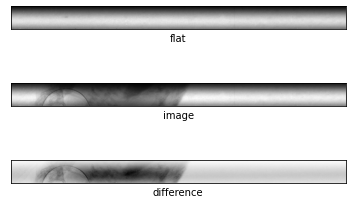

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import exposure

_filter = param["image_filter"]
m = param["filter_width"]
fig, axs = plt.subplots(ncols=1, nrows=3)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
idx = 0  # select from the list above


def scale(im):
    im = exposure.rescale_intensity(im, out_range="uint8")
    im = im.astype("uint8")
    return im


axs[0].imshow(scale(_filter(result1[idx], m)), cmap="gray")
axs[0].set(xlabel="flat")
axs[1].imshow(scale(_filter(result2[idx], m)), cmap="gray")
axs[1].set(xlabel="image")
axs[2].imshow(scale(_filter(result2[idx] - result1[idx], m)), cmap="gray")
axs[2].set(xlabel="difference");

## Save results

In [7]:
io.save_results(param, result1, result2)

## Looking at fitting details
It is useful to check a few points to see how the fits are working. For example if the data is read in the correct order or if the threshold is set too low. Select two points from the image to plot. Select one point in the background (bkg) and one in the object (obj).

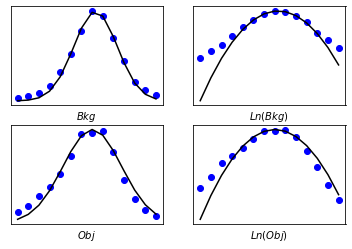

In [8]:
# pick two points
X = 80
Y1 = 800  # flat
Y2 = 1000  # image
pos = param["x-axis"]
flat_d = [im[X, Y1] for im in image]
image_d = [im[X, Y2] for im in image]
f_A, f_D, f_S, f_a, f_b, f_c = [result2[i][X, Y1] for i in range(6)]
i_A, i_D, i_S, i_a, i_b, i_c = [result2[i][X, Y2] for i in range(6)]
f_ln_fit = poly1d([f_c, f_b, f_a])
i_ln_fit = poly1d([i_c, i_b, i_a])


def e_func(f):
    def g(x):
        return exp(f(x))

    return g


f_fit = e_func(f_ln_fit)
i_fit = e_func(i_ln_fit)
# make plots
fig, axs = plt.subplots(ncols=2, nrows=2)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
axs[0, 0].plot(pos, flat_d, "bo", pos, f_fit(pos), "-k")
axs[0, 0].set_xlabel(r"$Bkg$")
axs[0, 1].plot(pos, log(flat_d), "bo", pos, f_ln_fit(pos), "-k")
axs[0, 1].set_xlabel(r"$Ln(Bkg)$")
axs[1, 0].plot(pos, image_d, "bo", pos, i_fit(pos), "-k")
axs[1, 0].set_xlabel(r"$Obj$")
axs[1, 1].plot(pos, log(image_d), "bo", pos, i_ln_fit(pos), "-k")
axs[1, 1].set_xlabel(r"$Ln(Obj)$");